In [111]:
import pandas as pd
import evalml
from evalml import AutoMLSearch
from evalml.preprocessing import split_data
from evalml.problem_types import ProblemTypes
from evalml.objectives.utils import get_optimization_objectives
from sklearn.metrics import classification_report

In [112]:
import torch

# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

# Move tensores/modelos para a GPU
tensor_cpu = torch.tensor([1.0, 2.0, 3.0])
tensor_gpu = tensor_cpu.to(device)  # Movendo para GPU

# Modelos também precisam ser movidos
model = torch.nn.Linear(3, 1).to(device)
output = model(tensor_gpu)  # Executa na GPU

Usando: cuda


base = pd.read_excel("../../Bases/Base_plano_Cartesiano.xlsx")
base.drop(columns=['V0024', 'UPA_PNS', 'V0006_PNS', 'C00301', 'C004', 'L01701', 'L018', 'M01601', 'Q11006'], inplace=True)

In [113]:
base = pd.read_excel("../../Bases/Base_tratada.xlsx")

### Treino e teste

In [114]:
X_prev = base.drop(columns=['Q074'])
y_classe = base['Q074']

In [115]:
X_train, X_test, y_train, y_test = split_data(X_prev, y_classe, problem_type='binary', test_size=0.3, random_seed=42)

/home/arthur/.local/lib/python3.12/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/home/arthur/.local/lib/python3.12/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/home/arthur/.local/lib/python3.12/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/home/arthur/.local/lib/python3.12/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed indivi

## AutoML

In [116]:
problem_type = ProblemTypes.BINARY 

In [117]:
print("Métricas permitidas para otimização:")
print([obj.name for obj in get_optimization_objectives('binary')])

Métricas permitidas para otimização:
['MCC Binary', 'Log Loss Binary', 'Gini', 'AUC', 'Precision', 'F1', 'Balanced Accuracy Binary', 'Accuracy Binary']


In [ ]:
automl = AutoMLSearch(
    X_train=X_train, 
    y_train=y_train,
    problem_type=problem_type,
    objective='log loss binary',  # Métrica de avaliação
    additional_objectives=['f1', 'Accuracy Binary', 'Balanced Accuracy Binary'],
    max_batches=50,
    # max_iterations=50,
    optimize_thresholds=True,
    
    # allowed_model_families=['random_forest', 'xgboost', 'linear_model', 'catboost', 'extra_trees', "linear_model", ],
    random_seed=42
)

In [119]:
automl.search()

{1: {'Random Forest Classifier w/ Label Encoder + Imputer + One Hot Encoder + Undersampler + RF Classifier Select From Model': 3.15895676612854,
  'Total time of batch': 3.273808002471924},
 2: {'LightGBM Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler': 1.564589500427246,
  'Extra Trees Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler': 2.012467384338379,
  'Elastic Net Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Standard Scaler + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Standard Scaler + Undersampler': 1.8659491539001465,
  'XGBoost Classifier w/ Label Encoder + 

### Resultados

In [120]:
print("\nRanking dos modelos:")
print(automl.rankings)


Ranking dos modelos:
        id                                      pipeline_name  search_order  \
0     1282  Random Forest Classifier w/ Label Encoder + Se...          1282   
220    227  Elastic Net Classifier w/ Label Encoder + Sele...           227   
565   1341  Extra Trees Classifier w/ Label Encoder + Sele...          1341   
635      1  Random Forest Classifier w/ Label Encoder + Im...             1   
906      6  Logistic Regression Classifier w/ Label Encode...             6   
1524     5  XGBoost Classifier w/ Label Encoder + Select C...             5   
1525     2  LightGBM Classifier w/ Label Encoder + Select ...             2   
1566     0       Mode Baseline Binary Classification Pipeline             0   

      ranking_score  mean_cv_score  standard_deviation_cv_score  \
0          0.303217       0.303217                     0.001601   
220        0.304236       0.304236                     0.000366   
565        0.304790       0.304790                     0.001178  

In [ ]:
best_pipeline = automl.best_pipeline
print("\nMelhor pipeline:", best_pipeline.name)
print("Parâmetros do melhor pipeline:", best_pipeline.parameters)


Melhor pipeline: Random Forest Classifier w/ Label Encoder + Select Columns By Type Transformer + Label Encoder + Imputer + Select Columns Transformer + Select Columns Transformer + Label Encoder + Imputer + One Hot Encoder + Undersampler
Parâmetros do melhor pipeline: {'Label Encoder': {'positive_label': None}, 'Numeric Pipeline - Select Columns By Type Transformer': {'column_types': ['category', 'EmailAddress', 'URL'], 'exclude': True}, 'Numeric Pipeline - Label Encoder': {'positive_label': None}, 'Numeric Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'most_frequent', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'Numeric Pipeline - Select Columns Transformer': {'columns': ['V0022', 'A02201|A02305|A02306', 'C006', 'C009', 'N010', 'P034|P035', 'Q092']}, 'Categorical Pipeline - Select Columns Transformer': {'columns': ['V0001', 'C008', 'P00104', 'P0

In [122]:
scores = best_pipeline.score(X_test, y_test, objectives=['log loss binary', 'f1', 'precision', 'recall'])
print("\nDesempenho no conjunto de teste:")
print(scores)


Desempenho no conjunto de teste:
OrderedDict({'Log Loss Binary': 0.3050503059160423, 'F1': 0.9689390883420734, 'Precision': 0.9397496087636933, 'Recall': 1.0})


In [123]:
predictions = best_pipeline.predict(X_test)
predict_proba = best_pipeline.predict_proba(X_test)

In [124]:
print("\nRelatório de Classificação por Classe:")
print(classification_report(y_test, predictions, target_names=['Nao tem asma', 'tem asma']))


Relatório de Classificação por Classe:
              precision    recall  f1-score   support

Nao tem asma       0.00      0.00      0.00       539
    tem asma       0.94      1.00      0.97      8407

    accuracy                           0.94      8946
   macro avg       0.47      0.50      0.48      8946
weighted avg       0.88      0.94      0.91      8946



/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [125]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Primeiro, vamos identificar quais são os rótulos únicos presentes nos dados
unique_labels = sorted(y_test.unique())
print(f"Rótulos encontrados: {unique_labels}")

# Agora vamos calcular as métricas usando os rótulos corretos
print("\nMétricas por classe:")
for label in unique_labels:
    print(f"\nClasse {label}:")
    print(f"Precisão: {precision_score(y_test, predictions, pos_label=label):.4f}")
    print(f"Recall: {recall_score(y_test, predictions, pos_label=label):.4f}")
    print(f"F1-Score: {f1_score(y_test, predictions, pos_label=label):.4f}")


Rótulos encontrados: [1, 2]

Métricas por classe:

Classe 1:
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Classe 2:
Precisão: 0.9397
Recall: 1.0000
F1-Score: 0.9689


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


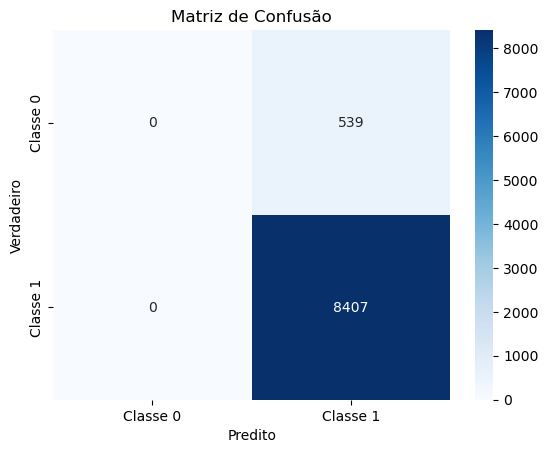

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()